In [2]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib as mpl 
import matplotlib.pyplot as plt 
%matplotlib inline
# 한글폰트 사용
mpl.rc('font', family='Malgun Gothic')
mpl.rc('axes', unicode_minus=False)
import warnings
warnings.filterwarnings("ignore")

In [3]:
from fbprophet import Prophet
from datetime import datetime

## 한국거래소(krx)에서 종목코드 가져오기
KOSPI, KOSDAQ


In [4]:
# 엑셀파일 다운로드 링크를 pd.read_html을 이용해서 바로 읽어오는 메소드
df = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download&searchType=13')[0]
df.head(3)


,회사명,종목코드,업종,주요제품,상장일,결산월,대표자명,홈페이지,지역
0,DSR,155660,1차 비철금속 제조업,합섬섬유로프,2013-05-15,12월,홍석빈,http://www.dsr.com,부산광역시
1,GS글로벌,1250,상품 종합 도매업,"수출입업(시멘트,철강금속,전기전자,섬유,기계화학),상품중개,광업,채석업/하수처리 서...",1976-06-26,12월,김태형,http://www.gsgcorp.com,서울특별시
2,HDC현대산업개발,294870,건물 건설업,"외주주택, 자체공사, 일반건축, 토목 등",2018-06-12,12월,"권순호, 정경구",http://www.hdc-dvp.com,서울특별시


In [5]:
# Series 모든 원소에 작용하는 map함수 (DataFrame에서의 apply함수)

# 종목코드는 6자리이기 때문에 6자리를 맞춰주기
df.종목코드 = df.종목코드.map('{:06d}'.format)

df = df[['회사명','종목코드']]
df.rename(columns = {
    '회사명':'name',
    '종목코드':'code'
},inplace=True)
df.name = df.name.str.strip()
df.code = df.code.str.strip()
df.head(3)

,name,code
0,DSR,155660
1,GS글로벌,001250
2,HDC현대산업개발,294870


In [6]:
df.query("name=='DSR'")['code'].to_string(index=False).strip()

'155660'

## 네이버금융에서 종목 별 일자 데이터 가져오기
http://finance.naver.com/item/sise_day.nhn?code=종목코드 
에서 일자 데이터를 가져올 수 있다.<br>
이후에는 1페이지에서 20페이지까지의 데이터만 가져오기로 한다 <br>

In [7]:
""" 종목 이름을 입력하면 종목에 해당하는 코드를 불러와 
네이버 금융(http://finance.naver.com)에 넣어줌 """

def get_url(item_name, code_df): 
    # 종목이름, 종목이름/종목코드 데이터프레임
    code = code_df.query(f"name=='{item_name}'")['code'].to_string(index=False).strip() 
    # query 메소드: 조건에 맞는 데이터를 뽑을 때 사용
    # 괄호 안에 조건연산자를 사용한 조건 사용
    # 빈 스페이스가 하나 붙어 나오길래 strip()사용
    url = f'http://finance.naver.com/item/sise_day.nhn?code={code}'
    
    print(f"요청 URL : {url}") 
    return url

In [8]:
item_name = '삼성전자'
url = get_url(item_name, df)

요청 URL : http://finance.naver.com/item/sise_day.nhn?code=005930


In [9]:
# 가져오는 데이터를 append method를 사용해서 행(가로)으로 붙일 것
# 빈 데이터프레임 준비
tmp = pd.DataFrame()

In [10]:
# 1페이지에서 20페이지의 데이터만 가져오기 => 총 200일만 들어와야 함
for page in range(1, 21): 
    pg_url = f'{url}&page={page}'
    tmp = tmp.append(pd.read_html(pg_url, header=0)[0], ignore_index=True)

# 총 200일만 들어와야 하는데 400, 600이 들어온다
## 날짜가 datetime, string 겹쳐서 들어오는 듯
## string을 datetime으로 바꾸고 다시 더하는 과정에서 중복이 되는 것으로 보임

In [11]:
tmp = tmp.dropna()
# 여기서 string을 datetime으로 바꿔버리니까 중복이 되는 것으로 보임
tmp.날짜 = tmp.날짜.str.strip()
tmp

,날짜,종가,전일비,시가,고가,저가,거래량
1,2020.12.09,72900.0,1200.0,72100.0,73300.0,72000.0,7636874.0
2,2020.12.08,71700.0,1200.0,72200.0,72900.0,71600.0,25000338.0
3,2020.12.07,72900.0,1400.0,72400.0,73500.0,71900.0,28490496.0
4,2020.12.04,71500.0,1800.0,70400.0,72100.0,70100.0,28130533.0
5,2020.12.03,69700.0,200.0,70100.0,70500.0,69300.0,23677989.0
...,...,...,...,...,...,...,...
294,2020.02.27,55900.0,600.0,56300.0,56900.0,55500.0,23209541.0
295,2020.02.26,56500.0,1400.0,56000.0,57000.0,56000.0,25483102.0
296,2020.02.25,57900.0,1100.0,56200.0,58000.0,56200.0,23885408.0
297,2020.02.24,56800.0,2400.0,57400.0,58100.0,56800.0,25627537.0


In [12]:
type(tmp['날짜'][1])

str

In [13]:
# 시계열 타입으로 바꿔주기
from dateutil.parser import parse
tmp['날짜'] = tmp['날짜'].map(parse)

In [14]:
type(tmp['날짜'][1])

pandas._libs.tslibs.timestamps.Timestamp

In [15]:
tmp.종가.dtype

dtype('float64')

In [16]:
GS = tmp[['날짜','종가']]

## naver, 카카오, LG 주식

In [17]:
stocks = ['NAVER','카카오','LG']
urls = []

In [18]:
for stock in stocks:
    urls.append(get_url(stock, df))
urls

요청 URL : http://finance.naver.com/item/sise_day.nhn?code=035420
요청 URL : http://finance.naver.com/item/sise_day.nhn?code=035720
요청 URL : http://finance.naver.com/item/sise_day.nhn?code=003550


['http://finance.naver.com/item/sise_day.nhn?code=035420',
 'http://finance.naver.com/item/sise_day.nhn?code=035720',
 'http://finance.naver.com/item/sise_day.nhn?code=003550']

In [19]:
from tqdm import tqdm
df_list = []

# 1페이지에서 20페이지의 데이터만 가져오기 
""" 여기서 문제는 없어보임 """
for url in tqdm(urls):
    for page in range(1, 21): 
        pg_url = f'{url}&page={page}'
        tmp = tmp.append(pd.read_html(pg_url, header=0)[0], ignore_index=True)
    df_list.append(tmp)

100%|██████████| 3/3 [00:12<00:00,  4.23s/it]


## 날짜가 두 번 들어오는 구간이 있어서 LG주식으로 확인 중
- 단일 페이지로 하면 string과 datetime이 겹쳐 들어오는 행이 없어 detect 실패
- LG, Kakao, naver 값이 LG 데이터프레임에 모두 같이 들어와있다. <br>
- 데이터프레임에 넣을 때 문제가 생겼다고 생각했으나 내 로직엔 문제가 없었고, 네이버 주식에서 올릴 때 문제가 있는듯

In [20]:
pg_url = f'{url}&page={7}'
pd.read_html(pg_url, header=0)[0]

,날짜,종가,전일비,시가,고가,저가,거래량
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2020.09.10,79700.0,200.0,80100.0,80800.0,79500.0,388054.0
2,2020.09.09,79500.0,0.0,78900.0,80400.0,78000.0,286174.0
3,2020.09.08,79500.0,500.0,80000.0,80400.0,79200.0,230927.0
4,2020.09.07,80000.0,100.0,79800.0,80300.0,79200.0,205067.0
5,2020.09.04,80100.0,2900.0,80600.0,81400.0,79800.0,360976.0
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,2020.09.03,83000.0,300.0,83600.0,84100.0,82600.0,330537.0


##  # datetime 객체를 문자열로

In [21]:
# datetime.strftime(naver['날짜'].to_numpy()[10],'%Y-%m-%d')

## # 시,분,초 까지 나와있는 datetime객체에서 년,월,일까지만 가져오기

In [22]:
# naver['날짜'].to_numpy()[10].date()

## # 문자열을 datetime 객체로

In [23]:
# parse(naver['날짜'].to_numpy()[201]).date()

In [24]:
naver = df_list[0].dropna()[['날짜','종가']]

In [25]:
naver[naver['날짜'] == datetime(2020, 2, 21).date()]

,날짜,종가
199,2020-02-21 00:00:00,59200.0


In [26]:
""" 
해당 코드는 시,분,초가 들어가 있는 datetime 객체에서 date()만 뽑아오는 방법이 틀렸을 때 코드
try:
    naver['날짜'] = naver.apply(lambda r: parse(r['날짜']).date(), axis=1)
except:
    naver['날짜'] = naver.apply(lambda r: datetime.strftime(r['날짜'],'%Y-%m-%d'), axis=1) 
"""

# 해당 코드는 string 날짜를 datetime으로 바꿔서 넣는 코드. 중복으로 들어와 결과가 틀리긴 했지만 좋은 코드
# naver['날짜'] = naver.apply(lambda r: parse(r['날짜']).date() if type(r['날짜']) == str else r['날짜'].date() , axis=1)

# string으로 들어오는 날짜의 종가 값이 보통 값보다 너무 많이 차이가 나 잘못된 값이라고 생각하고 제거
naver['날짜'] = naver.apply(lambda r: parse(r['날짜']).date() if type(r['날짜']) == str else '' , axis=1)

naver = naver[ naver['날짜'] != '']
naver

,날짜,종가
201,2020-12-09,287000.0
202,2020-12-08,285000.0
203,2020-12-07,289500.0
204,2020-12-04,294000.0
205,2020-12-03,287000.0
...,...,...
494,2020-02-27,182000.0
495,2020-02-26,187000.0
496,2020-02-25,190500.0
497,2020-02-24,184000.0


In [27]:
kakao = df_list[1].dropna()[['날짜','종가']]

kakao['날짜'] = kakao.apply(lambda r: parse(r['날짜']).date() if type(r['날짜']) == str else '' , axis=1)

kakao = kakao[ kakao['날짜'] != '']
kakao

,날짜,종가
201,2020-12-09,287000.0
202,2020-12-08,285000.0
203,2020-12-07,289500.0
204,2020-12-04,294000.0
205,2020-12-03,287000.0
...,...,...
794,2020-02-27,178500.0
795,2020-02-26,184000.0
796,2020-02-25,185500.0
797,2020-02-24,183500.0


In [28]:
kakao[kakao['날짜'] == datetime(2020, 2,20).date()]

,날짜,종가


# 여전히 같은 값으로 두 번 들어옴
- datetime으로 들어오는 값은 별로 차이가 나지 않고 더 이상 가릴 방법이 없어 pivot_table로 평균값을 냄

In [29]:
kakao = pd.pivot_table(data=kakao,
                       index='날짜',
                       values='종가',
                       aggfunc='mean')
kakao.reset_index(inplace=True)
kakao

,날짜,종가
0,2020-02-21,189500.0
1,2020-02-24,183750.0
2,2020-02-25,188000.0
3,2020-02-26,185500.0
4,2020-02-27,180250.0
...,...,...
195,2020-12-03,330500.0
196,2020-12-04,341750.0
197,2020-12-07,337250.0
198,2020-12-08,329750.0


In [30]:
LG = df_list[2].dropna()[['날짜','종가']]

LG['날짜'] = LG.apply(lambda r: parse(r['날짜']).date() if type(r['날짜']) == str else '' , axis=1)

LG = LG[ LG['날짜'] != '']
LG = pd.pivot_table(data=LG,
                       index='날짜',
                       values='종가',
                       aggfunc='mean')
LG.reset_index(inplace=True)
LG

,날짜,종가
0,2020-02-21,151100.000000
1,2020-02-24,146400.000000
2,2020-02-25,149233.333333
3,2020-02-26,147266.666667
4,2020-02-27,143500.000000
...,...,...
195,2020-12-03,244766.666667
196,2020-12-04,252533.333333
197,2020-12-07,249733.333333
198,2020-12-08,244833.333333


In [31]:
LG['날짜'].to_numpy()[:5]

array([datetime.date(2020, 2, 21), datetime.date(2020, 2, 24),
       datetime.date(2020, 2, 25), datetime.date(2020, 2, 26),
       datetime.date(2020, 2, 27)], dtype=object)

In [32]:
datetime(2020,2,21).date()

datetime.date(2020, 2, 21)

# Prophet

## model에 fit하기 위해서는 날짜 열의 이름을 ds로, 데이터 열의 이름을 y로 바꿔줘야 함

In [36]:
naver.rename(columns={'날짜':'ds','종가':'y'},inplace=True)
kakao.rename(columns={'날짜':'ds','종가':'y'},inplace=True)
LG.rename(columns={'날짜':'ds','종가':'y'},inplace=True)

In [39]:
model = Prophet(yearly_seasonality=True, daily_seasonality=True)
model.fit(naver)

In [40]:
future = model.make_future_dataframe(periods=60)

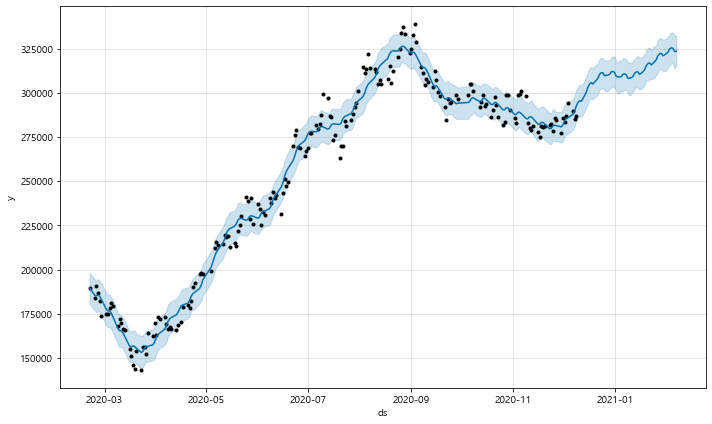

In [41]:
forecast = model.predict(future)
model.plot(forecast);

## 반복문 사용 불가. model이라는 한 변수에 계속 override 할 수 없음

In [43]:
model_kakao = Prophet(yearly_seasonality=True, daily_seasonality=True)
model_kakao.fit(kakao)

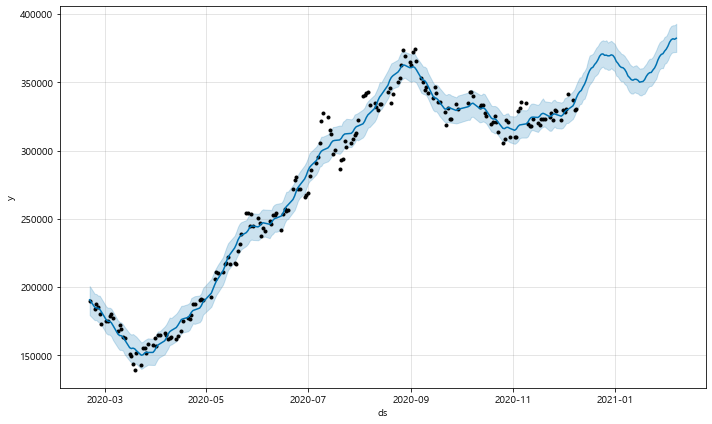

In [48]:
future_kakao = model_kakao.make_future_dataframe(periods=60)
forecast_kakao = model_kakao.predict(future_kakao)
model_kakao.plot(forecast_kakao);

In [49]:
model_naver = Prophet(yearly_seasonality=True, daily_seasonality=True)
model_naver.fit(naver)

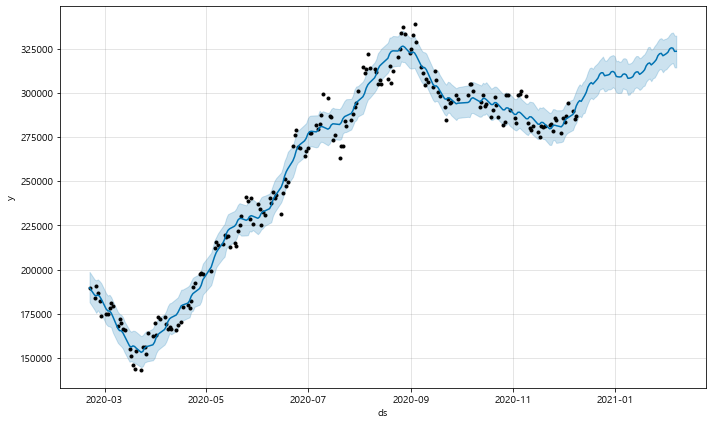

In [50]:
future_naver = model_naver.make_future_dataframe(periods=60)
forecast_naver = model_naver.predict(future_naver)
model_naver.plot(forecast_naver);

## 3~4월 코로나 때문에 모든 주식이 많이 내려간 이후 다시 회복하는 중